## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

In [1]:
## Importing the Libraries
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
# print head of data frame with help of head function
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

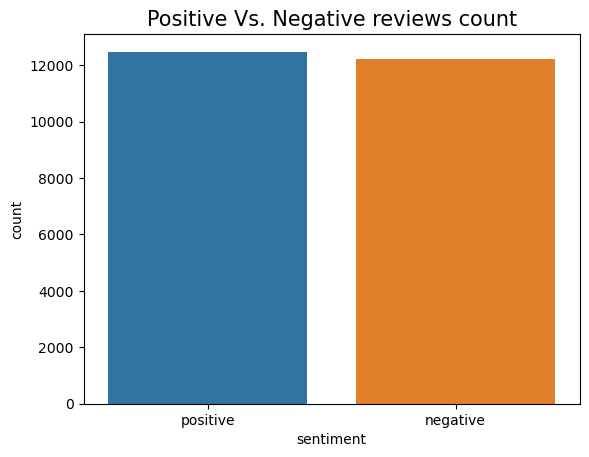

In [4]:
# plots the sentiment counts
plt.figure(figsize = None)
sns.countplot(x = 'sentiment', data = df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [5]:
# hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df.loc[df['sentiment'] == 'positive']
df_minority = df.loc[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

# concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = pd.concat([df_majority, negative_upsample])
df_upsampled = df_upsampled.sample(frac = 1)

In [6]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell.

# print the shape of data set with the help of shape function having "negative" as class label
print(df_upsampled[df_upsampled['sentiment'] == 'negative'].shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [7]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
print(df_upsampled[df_upsampled['sentiment'] == 'positive'].shape)

(12474, 2)


### Expected Output : 
(12474, 2)

In [8]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])


In [9]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 

print(y_train.value_counts())

positive    10000
negative    10000
Name: sentiment, dtype: int64


### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [10]:
print(y_test.value_counts())

positive    2474
negative    2474
Name: sentiment, dtype: int64


### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [11]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''   
    # convert to lowercase
    review = review.lower()
    
    # remove links i.e. <br> tags
    review = re.sub("<br />", " ", review)
    
    # remove punctuations
    review = review.translate(str.maketrans('', '', string.punctuation))
    
    # remove stopwords
    word_tokens = word_tokenize(review)
    stop_words = set(stopwords.words('english'))
    word_tokens_without_sw = [word for word in word_tokens if not word in stop_words]
    
    # concatenate word tokens without sw to form a sentence
    filtered_words = (" ").join(word_tokens_without_sw)
    
    # stemming operation
    word_tokens = word_tokenize(filtered_words)
    lemmatizer = WordNetLemmatizer()
    singles = [lemmatizer.lemmatize(word) for word in word_tokens]
    
    # concatenate word tokens back to form a sentence
    review_cleaned = (" ").join(singles)
    
    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [12]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    
    # given the word and label, it finds the frequency else returns 0
    return frequency.get((word, label), 0); 

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [13]:
# With the use of mapping function, we replace the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [14]:
# Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [15]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'This movie tells the story of nine ambitious teens trying to follow their dream at the infamous New York High School For Performing Arts: Coco, the singer, Bruno, the modern Mozart, Lisa, Leroy, and Hilary, the struggling dancers, Ralph, the comedian, and Doris and Montgomery, the actors. While they all think they have what it takes to really reach their goals, they are going to need a lot more than just their talent. They will have to deal with rejection, heartbreak, education, pain, and love in order to achieve their fame.<br /><br />"Fame" is one of the most entertaining, classic, and inspirational movies of all time. It has everything a teen drama/musical should have: extremely catchy, entertaining, Oscar-winning songs performed by the amazing Irene Cara, stunning dance numbers, a very attractive cast that makes you believe in the characters, and a great story, including the heartbreaking scene when Coco meets the video camera.<br /><br />Like I said, the cast is awesome. Irene Ca

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [16]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

movie tell story nine ambitious teen trying follow dream infamous new york high school performing art coco singer bruno modern mozart lisa leroy hilary struggling dancer ralph comedian doris montgomery actor think take really reach goal going need lot talent deal rejection heartbreak education pain love order achieve fame fame one entertaining classic inspirational movie time everything teen dramamusical extremely catchy entertaining oscarwinning song performed amazing irene cara stunning dance number attractive cast make believe character great story including heartbreaking scene coco meet video camera like said cast awesome irene cara really act singing make shine coco lee curreri good bruno barry miller brings lot humor ralph maureen teefy great outcast doris look closely youll see paul mccrane er montgomery truly amazing film fame really touched inspired keep following dream actor singer movie move much winner book mustsee film really touched inspired follow dream actor singer


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [17]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
        # clean up the review
        split_review = clean_review(review).split()
        for word in split_review:
            # Your code here
            key = (word, label)
            if key in output_occurrence:
                output_occurrence[key] = output_occurrence.get(key) + 1
            else:
                output_occurrence[key] = 1
   
    return output_occurrence

### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [18]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [19]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [20]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('movie', 0): 17565,
 ('tell', 0): 1000,
 ('story', 0): 5590,
 ('nine', 0): 64,
 ('ambitious', 0): 64,
 ('teen', 0): 228,
 ('trying', 0): 775,
 ('follow', 0): 299,
 ('dream', 0): 455,
 ('infamous', 0): 57,
 ('new', 0): 1824,
 ('york', 0): 365,
 ('high', 0): 714,
 ('school', 0): 621,
 ('performing', 0): 59,
 ('art', 0): 664,
 ('coco', 0): 3,
 ('singer', 0): 151,
 ('bruno', 0): 66,
 ('modern', 0): 445,
 ('mozart', 0): 4,
 ('lisa', 0): 63,
 ('leroy', 0): 7,
 ('hilary', 0): 13,
 ('struggling', 0): 55,
 ('dancer', 0): 110,
 ('ralph', 0): 69,
 ('comedian', 0): 98,
 ('doris', 0): 34,
 ('montgomery', 0): 68,
 ('actor', 0): 2382,
 ('think', 0): 3037,
 ('take', 0): 2344,
 ('really', 0): 4300,
 ('reach', 0): 158,
 ('goal', 0): 72,
 ('going', 0): 1405,
 ('need', 0): 979,
 ('lot', 0): 2003,
 ('talent', 0): 428,
 ('deal', 0): 504,
 ('rejection', 0): 22,
 ('heartbreak', 0): 10,
 ('education', 0): 46,
 ('pain', 0): 161,
 ('love', 0): 3601,
 ('order', 0): 433,
 ('achieve', 0): 81,
 ('fame', 0): 104,
 

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [21]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set(pair[0] for pair in freqs.keys())
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive
        if pair[1] == 0:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs.get(pair)

        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs.get(pair)

    # calculate num_doc, the number of documents
    num_doc = len(train_x)
    
    # calculate D_pos and D_neg
    d_pos = d_neg = 0
    
    for label in train_y:
        if label == 0:
            d_pos += 1 
        else:
            d_neg += 1

    # calculate D_pos, the number of positive documents 
    pos_num_docs = d_pos
    
    # calculate D_neg, the number of negative documents 
    neg_num_docs = d_neg

    # calculate logprior
    logprior = math.log(neg_num_docs / pos_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)
        
        # calculate the log likelihood of the word
        loglikelihood[word] = math.log(p_w_neg / p_w_pos)

    return logprior, loglikelihood

In [22]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
84766


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [23]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    # process the review to get a list of words
    word_l = word_tokenize(clean_review(review))

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood.get(word)

    if total_prob > 0:
        total_prob = 1
    else:
        total_prob = 0

    return total_prob

In [24]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [25]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    y_hats = []
    for review in test_x:
        pred = naive_bayes_predict(review, logprior, loglikelihood)
        # if the prediction is > 0
        if pred > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y    
    num_errors = 0
    for x, y in zip(y_hats, test_y):
        if x != y:
            num_errors +=1
    
    error = num_errors / len(y_hats)
    
    # accuracy
    accuracy = (len(y_hats) - num_errors) / len(y_hats)

    return accuracy, y_hats

In [26]:
accuracy, y_hats = test_naive_bayes(X_test, y_test, logprior, loglikelihood)
print(accuracy)

0.8779304769603881


In [27]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [28]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [29]:
def split_dataset(X, y, size, seed):
    """
    Input:
        X: a list of reviews
        y: the corresponding labels for the list of reviews
        size: proportion of dataset to be included in the test split
        seed: controls the shuffling applied to the data before applying the split
    Output:
        X_train: returns a list of reviews that classifier needs to train on train dataset
        X_test: returns a list of reviews that classifier needs to test on test dataset
        y_train: return the corresponding labels for the list of review that the classifier trained on i.e. gold values
        y_test: return the corresponding labels for the list of review that the classifier tested on i.e. gold values
    """
    
    # using the train test split function
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=size)
    
    # With the use of mapping function, we replace the label in the form of string to an integer. 
    output_map = {'positive': 0, 'negative': 1}
    y_train = y_train.map(output_map)
    y_test = y_test.map(output_map)
    
    return X_train, X_test, y_train, y_test

In [30]:
X = df_upsampled['review']
y = df_upsampled['sentiment']

# split data
X_train, X_test, y_train, y_test = split_dataset(X, y, 0.3, 0)

# build freqs dictionary
freqs = review_counter({}, X_train, y_train)

# train 'train set' on naive bayes
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)

# confusion matrix for train
accuracy_train, y_pred_train = test_naive_bayes(X_train, y_train, logprior, loglikelihood)
train_cm = confusion_matrix(y_train, y_pred_train)

# confusion matrix for test
accuracy_test, y_pred_test = test_naive_bayes(X_test, y_test, logprior, loglikelihood)
test_cm = confusion_matrix(y_test, y_pred_test)

In [31]:
def cal_accuracy(cm):
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    
    return (TP + TN) / (TP + TN + FP + FN)

Confusion Matrix for training set: 
 [[7981  759]
 [ 314 8409]]

Accuracy of training set:  0.9385558036992498


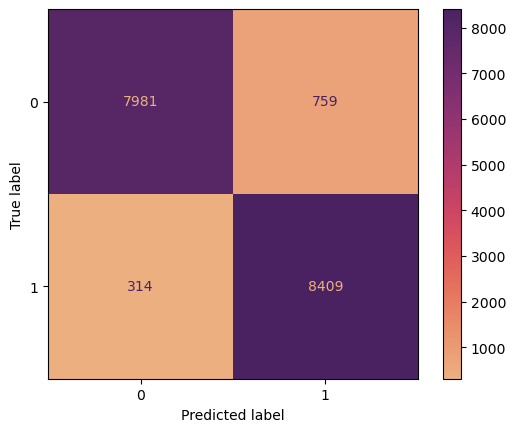

In [32]:
print("Confusion Matrix for training set: \n", train_cm)
disp = ConfusionMatrixDisplay(train_cm)
disp.plot(cmap = "flare")

print("\nAccuracy of training set: ", cal_accuracy(train_cm))


Confusion Matrix for test set: 
 [[3183  551]
 [ 350 3401]]

Accuracy of test set:  0.879625918503674


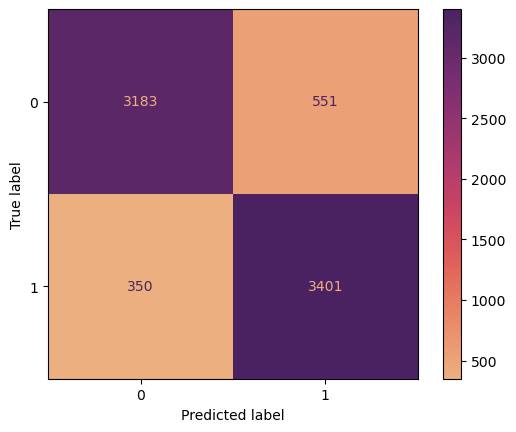

In [33]:
print("\nConfusion Matrix for test set: \n", test_cm)
disp = ConfusionMatrixDisplay(test_cm)
disp.plot(cmap = "flare")

print("\nAccuracy of test set: ", cal_accuracy(test_cm))

In [34]:
# find misclassified data for train and test 
def misclassified_data(X, y, y_pred):
    """
    Input:
        X: a list of reviews
        y: the corresponding labels for the list of reviews
        y_pred: predicted labels for the list of reviews
    Output:
        prints five false negative and false positives misclassified reviews
    """
    
    # initialize false negative count
    fn = 0
    for review, truth, pred in zip(X, y, y_pred):
        if fn == 5:
            break

        # find false negative cases
        if (truth == 0) and (pred == 1):
            fn += 1
            print("False Negative Review #", fn, ":", "\n", review, "\n")
    
    # initialize false positive count
    fp = 0
    for review, truth, pred in zip(X, y, y_pred):
        if fp == 5:
            break
        
        # find false positive cases
        if (truth == 1) and (pred == 0):
            fp += 1
            print("False Positive Review #", fp, ":", "\n", review, "\n")

In [35]:
# train dataset misclassification
misclassified_data(X_train, y_train, y_pred_train)

False Negative Review # 1 : 
 Sunny, a cocktail waitress in the D.C. area, is a bit dim, to put in mildly. She drives an old clunker and rents a tiny room from a gay male couple. However, she saves the life of a prominent Arab, by taking a bullet in the behind that was meant for the official. She charms the national press with her zany remarks and her sweet looks. Sniffing an opportunity, Presidential aides get her installed in the protocol department for the U.S. government. Even then, she messes things up at times, but she tries hard and learns a lot. She even grabs the romantic attention of a State department official. But, is there another sinister plot in the making, involving an Arab man who wishes to take another wife? A blonde one? LOL, LOL, LOL. This movie features Goldie as pretty as a picture and as dumb "as a fox", as they say. Sunny learns her way around the jungle of the U.S. government very, very well. She even has important things to say about honesty and the lack of it

In [36]:
# test dataset misclassification
misclassified_data(X_test, y_test, y_pred_test)

False Negative Review # 1 : 
 This movie is just about as good as the first Jackass, but with slightly more disgusting skits. I wouldn't say this was as good as the first, but it came very close. Jackass fans will not be disappointed, but if you didn't like the first movie, you will hate this one. There are scenes that will be seen as Jackass classics (the elderly suits with "additions", the "cab ride", and many others), and those that you will wish you never watched (eating crap, drinking semen, etc...) Overall this movie was a good watch, and I am glad I got to see it. I'm sure this movie will not have the best rating due to critics that rate it (I sat in the press section and most of the older viewers seemed disgusted), but don't let that stop you from enjoying it. 

False Negative Review # 2 : 
 I remember watching American Gothic when it first aired, it came into my mind recently, all I could remember was the same guy appeared in Midnight Caller, which is Gary Cole, I don't watch 

## Reasoning for why reviews get misclassified:

One of the reasons why reviews are misclassified is because of the process of sentiment analysis. Given reviews may contain certain positive tokens with higher frequency than the negative tokens, and therefore are misclassified even though they convey 
negative feedback. 

For instance, "As with many sequels, this one just doesn't have the quality or the impact of the original. The first one belongs up there with the rest of the greats. This one just doesn't cut it. The first film had a magical "good time" feeling about it that is totally missing from this film."  The tokens like "greats", "good", etc. are usually associated with positive sentiment and therefore, the review is classified as false positive. Similarily, negative tokens are usually associated with negative sentiment and therefore, such reviews are classified as false negatives even though the review may actually be conveying positive feedback. In this way, the frequency of positive and negative sentiments of tokens affects the overall classification decision. 


# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [37]:
# writes current dataset logprior and loglikelihood values to a .txt file for predicting user given reviews in the 
# text_classifier.py

f = open("pre_train_prior_likelihood.txt", "w", encoding='utf-8')
f.write(str(logprior) + "\n")

for k,v in loglikelihood.items():
    f.write(str(k) + ',' + str(v) + '\n')

f.close()

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)


Answers:

1. Laplace Smoothing is required to solve the problem of zero probability i.e. when a query point contains new observation, which is not observed during training while calculating probabilities. The idea is to never have zero probbability for posterior when computing probability for given features. So, to avoid such issues is to add-one (Laplace) smoothing. Let's illustrate with an example if additive smoothing wasn't applied to dataset and how it can lead to unwanted outcomes. In our training dataset, we have simple positive comments such as "The movie is great", "I enjoyed the movie", etc., however, in test dataset, we encountered complex positive comments with unknown tokens such as "The movie facinates me". The algorithm can distinguish between words that appeared in the vocabulary, but not words like "fascinates". Thus, it will lead to zero probability when classifying the review and ultimaltely, misclassifying the review. 


2. Naive Bayes algorithm calculations are computed in logarithmic space to avoid underflow and increase speed. If only probability values are used, multiplying very small numbers will lead to even smaller numbers and it will be difficult to store and compare these very small numbers. Therefore, logarithmic function will solve this problem by mapping the probability values from [0,1] range to the (-inf,0] range. Additionally, computation overhead of multiplication operation is extremely expensive and thus, log can increase the speed by turning multiplication to addition operations. 